In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import keras
import tensorflow as tf
import numpy as np
from numpy import argmax
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, Flatten                                   
from tensorflow.keras.layers import AveragePooling2D, Input, MaxPool2D, Dropout, Add, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from keras.constraints import maxnorm 
from sklearn.model_selection import train_test_split

In [4]:
tf.test.gpu_device_name() # If the GPU is enabled, it will give the following output '/device:GPU:0'

'/device:GPU:0'

In [ ]:
# unzip the train images file
!unzip -u "/content/drive/My Drive/train_images.zip" -d "/content/drive/My Drive/train_images"

Archive:  /content/drive/My Drive/train_images.zip


In [ ]:
# unzip the test images file
!unzip -u "/content/drive/My Drive/test_images.zip" -d "/content/drive/My Drive/test_images"

Archive:  /content/drive/My Drive/test_images.zip


In [5]:
train_images = '/content/drive/MyDrive/train_images/' 
test_images = '/content/drive/MyDrive/test_images/'  

In [8]:
df = pd.read_csv('/content/drive/MyDrive/labels_train.csv') # convert the labels_train.csv to pandas dataframe
df.head()

,file_name,class_id
0,img_4358977458434011046.jpg,1
1,img_5224016757187192130.jpg,2
2,img_3065202206106254707.jpg,2
3,img_6304894865561547174.jpg,1
4,img_3371338542810939877.jpg,2


In [9]:
# separate file names and labels from the dataframe
file_images = df['file_name'].values
labels = df['class_id'].values

In [10]:
img_size = 224


def create_train_data(images, labels):
  
  #images = file paths of the training images
  #lables = labels of the training images

   
  X = []
  X_label = []
  for i in range(len(images)):
    img_array = cv2.imread(os.path.join(train_images,images[i]), cv2.IMREAD_GRAYSCALE) # convert the images into arrays
    resized_array = cv2.resize(img_array, (img_size, img_size)) # resize the images
    #append each image to a list and return the lists as np.array objects.
    X.append(resized_array)
    X_label.append(labels[i]) 
    
  return np.array(X), np.array(X_label)

def create_test_data(images):

  X = []
  for i in range(len(images)):
    img_array = cv2.imread(os.path.join(test_images,images[i]), cv2.IMREAD_GRAYSCALE)
    resized_array = cv2.resize(img_array, (img_size, img_size))

    X.append(resized_array)
    
  return np.array(X) # returns one np.array variable of the test images

In [11]:
X_train, X_train_labels = create_train_data(file_paths, labels)

In [12]:
'''

The train set is being randomly splitted into train and validation data.
90% for the new train data
10% for the validation data

'''

X_train, X_val, Y_train, Y_val = train_test_split(X_train, X_train_labels, test_size=0.1, random_state=1)

In [13]:
# Save the training and validation image data, as well as their associated labels, as npy files

np.save('/content/drive/MyDrive/X_train.npy', X_train, allow_pickle=True)
np.save('/content/drive/MyDrive/Y_train.npy', Y_train, allow_pickle=True)

np.save('/content/drive/MyDrive/X_val.npy', X_val, allow_pickle=True)
np.save('/content/drive/MyDrive/Y_val.npy', Y_val, allow_pickle=True)

In [14]:
test_images_names = [img for img in os.listdir(test_images_dir)] 

df_test = pd.DataFrame (test_images_names, columns=['file_name']) # Save the above list in a pandas Dataframe with column name 'file_name'

file_paths_test = df_test['file_name'].values # Use the the dataframe to get an array of test images names to feed in the create_test_data function

df_test.head()

,file_name
0,img_1947126793031742593.jpg
1,img_2031896927656989520.jpg
2,img_2257305286976174058.jpg
3,img_226614577145440113.jpg
4,img_2278177160359080723.jpg


In [15]:
X_test = create_test_data(file_paths_test)

In [16]:
# Save the processed test images data as npy file
np.save('/content/drive/MyDrive/X_test.npy', X_test, allow_pickle=True)

In [17]:
# Load Saved data from drive
X_train_loaded = np.load('/content/drive/MyDrive/X_train.npy', allow_pickle=True) #train set
Y_train = np.load('/content/drive/MyDrive/Y_train.npy', allow_pickle=True) #train labels

X_val_loaded = np.load('/content/drive/MyDrive/X_val.npy', allow_pickle=True) #validation set
Y_val = np.load('/content/drive/MyDrive/Y_val.npy', allow_pickle=True) #validation labels

X_test_loaded = np.load('/content/drive/MyDrive/X_test.npy', allow_pickle=True) #test set

Text(0.5, 1.0, 'Viral Pneumonia')

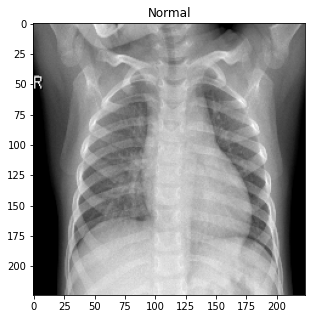

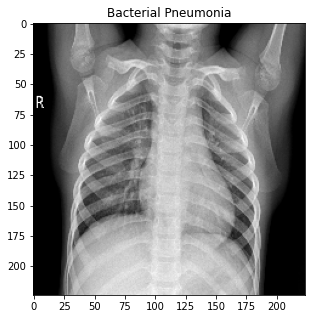

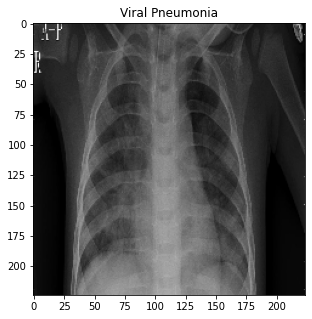

In [18]:
plt.figure(figsize = (5,5))
plt.imshow(X_train_loaded[5], cmap='gray')
plt.title("Normal")

plt.figure(figsize = (5,5))
plt.imshow(X_train_loaded[1], cmap='gray')
plt.title("Bacterial Pneumonia")

plt.figure(figsize = (5,5))
plt.imshow(X_train_loaded[2], cmap='gray')
plt.title("Viral Pneumonia")

In [19]:
# Preprocessing Train and Validation data
# Reshaping the data helps the model to input the data properly
X_train = np.reshape(X_train_loaded, [-1,img_size,img_size,1])
X_val = np.reshape(X_val_loaded, [-1,img_size,img_size,1])

# Input image dimensions
input_shape = X_train.shape[1:]

# Normalizing
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

# Subtracting the train data mean from Train and Validation data
X_train_mean = np.mean(X_train, axis=0)

X_train -= X_train_mean
X_val -= X_train_mean

In [20]:
# Preprocessing Test data
# Reshaping
X_test = np.reshape(X_test_loaded, [-1,img_size,img_size,1])

# Normalizing
X_test = X_test.astype('float32') / 255.0

# Subtracting the train data mean from Test data
X_test -= X_train_mean

In [22]:
# Transform labels to one hot encoded
Y_train_new = to_categorical(Y_train)
Y_val_new = to_categorical(Y_val)

In [23]:
# the learning rate scheduler will be reduced after 40 and 30 epochs
def lr_schedule(epoch): 
  
  lr = 1e-3
  if epoch > 40:
      lr *= 1e-2
  elif epoch > 30:
      lr *= 1e-1
  return lr

In [24]:
datagen = ImageDataGenerator(
        rotation_range = 10,  # rotates images in the range of 10 degrees
        zoom_range = 0.1, # zooms image up to 90% of the original image
        width_shift_range=0.1,  # randomly shift images horizontally, 10% fraction of total width
        height_shift_range=0.1)  # randomly shift images vertically, 10% fraction of total height

datagen.fit(X_train)

In [25]:

num_classes = 3

def cnn_model(input_shape):
  x_in = Input(shape=input_shape)

    
  x = Conv2D(filters=16, kernel_size= 5, padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x_in)
  x = MaxPool2D(pool_size= 2)(x) 
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPool2D(pool_size= 2)(x) 
  x = Conv2D(filters=64, kernel_size= 1, padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x) #14
  x = BatchNormalization()(x) 

  x = Conv2D(filters=64, kernel_size= 1, padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
  x = BatchNormalization()(x)
  

  x = AveragePooling2D(pool_size= 2)(x)

  x = Flatten()(x)
  x = Dense(126, activation='relu', kernel_initializer='he_normal')(x)
  x = Dense(126, activation='relu', kernel_initializer='he_normal')(x)
  x = Dense(42, activation='relu', kernel_initializer='he_normal')(x)
  x = Dropout(rate=0.2)(x)
  out = Dense(num_classes, activation='softmax', kernel_initializer='he_normal')(x)

  model = Model(inputs=x_in, outputs=out)
  return model

In [26]:
res_model = cnn_model(input_shape)

res_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
res_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 112, 112, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 64)        1088  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


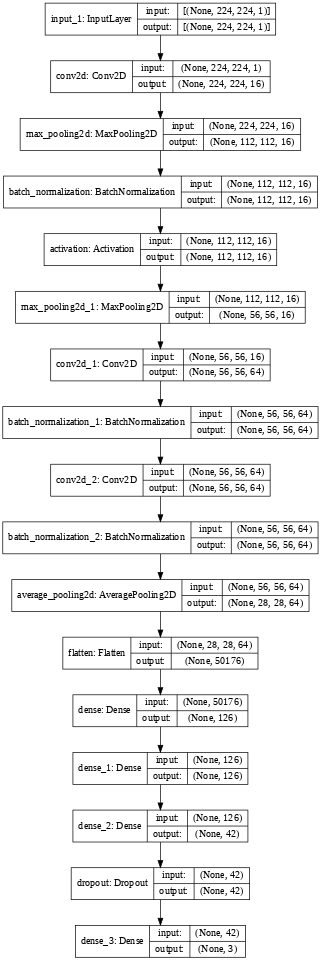

In [27]:
plot_model(res_model, show_shapes=True, dpi=50)

In [28]:
max_epochs = 20
batch_size = 40

#passing the lr_schedule function through the in-build method of keras, LearningRateScheduler
lr_scheduler = LearningRateScheduler(lr_schedule) 


In [29]:
#create a checkpoint to save the model with the best validation accuracy
checkpoint = ModelCheckpoint('model.h5', 
                             verbose=1, 
                             monitor='val_accuracy', 
                             save_best_only=True)

In [30]:
#create a learning rate reducer that activates if the validation accuracy is forming a plateau for up to 5 epochs
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience = 5, 
                                            verbose=1, 
                                            factor=np.sqrt(0.1), 
                                            min_lr=0.000001)

In [31]:

history_res = res_model.fit(datagen.flow(X_train,Y_train_new, batch_size = batch_size),
                    epochs = max_epochs,
                    verbose = 1, 
                    validation_data = datagen.flow(X_val, Y_val_new),
                    callbacks = [learning_rate_reduction, lr_scheduler, checkpoint])

Epoch 1/20
106/106 [==============================] - 48s 179ms/step - loss: 1.4259 - accuracy: 0.6287 - val_loss: 2.2810 - val_accuracy: 0.4765

Epoch 00001: val_accuracy improved from -inf to 0.47650, saving model to model.h5
Epoch 2/20
106/106 [==============================] - 18s 173ms/step - loss: 0.7044 - accuracy: 0.7067 - val_loss: 1.8495 - val_accuracy: 0.4808

Epoch 00002: val_accuracy improved from 0.47650 to 0.48077, saving model to model.h5
Epoch 3/20
106/106 [==============================] - 18s 174ms/step - loss: 0.6509 - accuracy: 0.7374 - val_loss: 1.3790 - val_accuracy: 0.5107

Epoch 00003: val_accuracy improved from 0.48077 to 0.51068, saving model to model.h5
Epoch 4/20
106/106 [==============================] - 19s 177ms/step - loss: 0.6087 - accuracy: 0.7460 - val_loss: 0.8545 - val_accuracy: 0.6902

Epoch 00004: val_accuracy improved from 0.51068 to 0.69017, saving model to model.h5
Epoch 5/20
106/106 [==============================] - 19s 176ms/step - loss: 0.

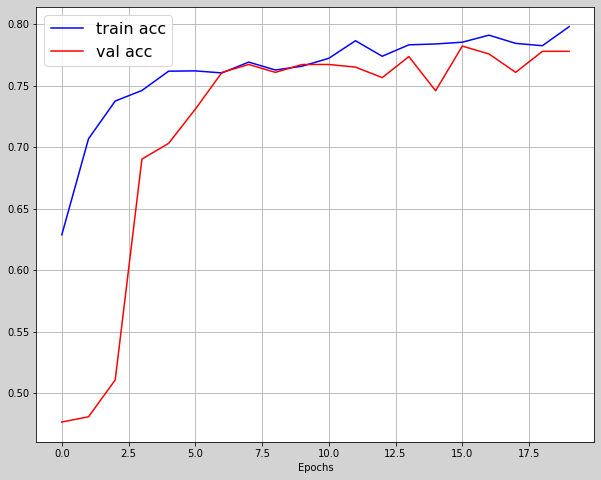

In [32]:

fig, ax = plt.subplots(figsize=(10,8))
fig.set_facecolor('lightgray')
plt.plot(history_res.history['accuracy'], 'b')
plt.plot(history_res.history['val_accuracy'], 'r')
plt.legend(['train acc', 'val acc'], fontsize=16)
plt.xlabel('Epochs')
plt.grid(b=True)


In [33]:
Y_test_prob = res_model.predict(X_test)
print(Y_test_prob)

[[1.47790974e-02 4.18126673e-01 5.67094266e-01]
 [9.99930263e-01 2.67888681e-05 4.28890744e-05]
 [1.45999373e-08 9.56903338e-01 4.30967025e-02]
 ...
 [1.05639495e-01 4.42715853e-01 4.51644689e-01]
 [3.10874909e-01 3.86880636e-01 3.02244514e-01]
 [2.94784307e-01 4.70027804e-01 2.35187858e-01]]


In [35]:
df_test['class_id'] = Y_test
df_test.head()

,file_name,class_id
0,img_1947126793031742593.jpg,2
1,img_2031896927656989520.jpg,0
2,img_2257305286976174058.jpg,1
3,img_226614577145440113.jpg,1
4,img_2278177160359080723.jpg,1


In [36]:
df_test.shape


(1168, 2)

In [90]:
#Save a csv file of the outcome to the drive
df_test.to_csv('/content/drive/MyDrive/submission.csv', sep = ',', index = False)